#**Sign Language Detector**
We will select the Run Time as GPU to ensure accelerated computation

#**Step 01: Installing the required Packages**




In [1]:
%%capture
!pip install super-gradients #provides functionality for advanced gradient operations
!pip install imutils #offers a collection of convenient functions for OpenCV
!pip install roboflow # for working with Roboflow, a platform for training and deploying computer vision models.
!pip install pytube --upgrade #for interacting with YouTube videos and data

#**Step 02: Importing all the required libraries**

In [30]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [3]:
from IPython.display import clear_output


In [4]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [5]:
from super_gradients.training import models


#**Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [6]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='sign_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 04: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RYY4jV9XxxeCFG6auxJ0")
project = rf.workspace("david-lee-d0rhs").project("american-sign-language-letters")
dataset = project.version(6).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch::   6%|▌         | 87/1452 [00:00<00:01, 785.97it/s]

Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch:: 100%|██████████| 1452/1452 [00:01<00:00, 829.53it/s]


#**Step 05: Load our dataset parameters into a dictionary**

We tried to load our dataset parameters into a dictionary, specifically defining:

- path to the parent directory where our data lives
- the child directory names for training, validation, and test images and labels
- class names

In [8]:
dataset_params = {
    'data_dir':'/content/American-Sign-Language-Letters-6',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J', 'K', 'L','M','N','O', 'P', 'Q', 'R', 'S', 'T', 'U',  'V', 'W', 'X', 'Y', 'Z']
}



#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [9]:
# The following code sets up data loaders for training, validation, and testing datasets in the COCO format
# with YOLO-style labels.

# Create a data loader for the training dataset.
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],         # Main data directory
        'images_dir': dataset_params['train_images_dir'],  # Directory containing training images
        'labels_dir': dataset_params['train_labels_dir'],  # Directory containing training labels
        'classes': dataset_params['classes']              # List of classes or object labels
    },
    dataloader_params={
        'batch_size': 16,       # Batch size for training
        'num_workers': 2        # Number of worker processes for data loading
    }
)

# Create a data loader for the validation dataset.
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],         # Main data directory
        'images_dir': dataset_params['val_images_dir'],    # Directory containing validation images
        'labels_dir': dataset_params['val_labels_dir'],    # Directory containing validation labels
        'classes': dataset_params['classes']              # List of classes or object labels
    },
    dataloader_params={
        'batch_size': 16,       # Batch size for validation
        'num_workers': 2        # Number of worker processes for data loading
    }
)

# Create a data loader for the test dataset.
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],         # Main data directory
        'images_dir': dataset_params['test_images_dir'],  # Directory containing test images
        'labels_dir': dataset_params['test_labels_dir'],  # Directory containing test labels
        'classes': dataset_params['classes']              # List of classes or object labels
    },
    dataloader_params={
        'batch_size': 16,       # Batch size for testing
        'num_workers': 2        # Number of worker processes for data loading
    }
)

# Clear the output (optional) to keep the workspace tidy.
clear_output()


#**Step 07: Inspect the Dataset Defined Earlier**

In [10]:
# The following line accesses the transforms applied to the training dataset.
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [11]:
# The following code accesses a specific transformation in the training dataset's parameters.
# '[1]' accesses the second transformation in the list (0-based indexing).
train_data.dataset.dataset_params['transforms'][1]


{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [12]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

Indexing dataset annotations: 100%|██████████| 72/72 [00:00<00:00, 3072.25it/s]


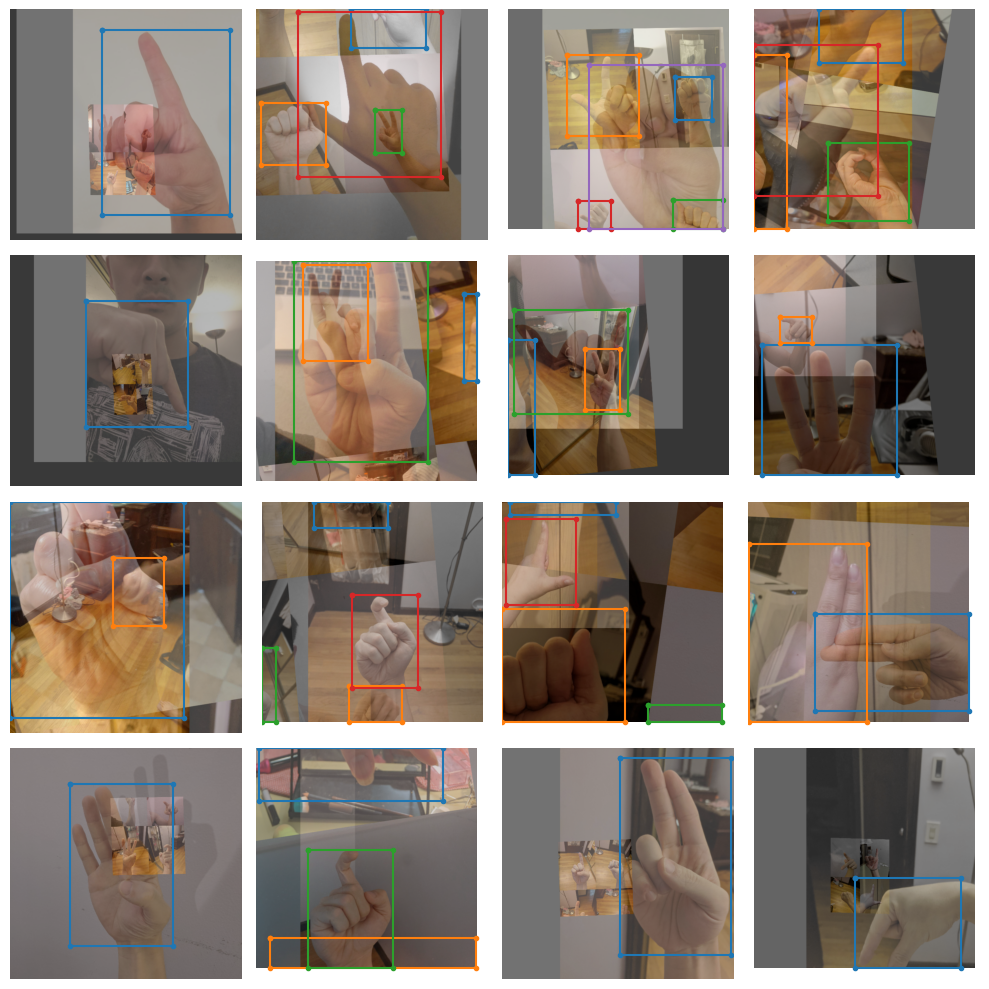

In [13]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**


We managed to instantiate the model for inference earlier.

We will proceed now to instantiate the model for finetuning. Note we need to add the `num_classes` argument here.

Note, for this project we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [14]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-10-30 01:38:35] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 113MB/s]
[2023-10-30 01:38:36] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


#**Step 10: Define metrics and training parameters**


We need to define the training parameters for our training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### There are a few **mandatory** arguments that we must define for training params

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. we will go with Adam in this project.


In [15]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 11: Download the Demo Videos**

In [16]:
!gdown "https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t
To: /content/demonew1.mp4
100% 1.26M/1.26M [00:00<00:00, 13.3MB/s]


In [17]:
!gdown "https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t"



```
# This is formatted as code
```

#**Step 12: Training the model**

we've covered so far:

✅ Instantiated the trainer

✅ Defined our dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up our training parameters

### Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.



In [18]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t 



[2023-10-30 01:38:51] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231030_013851_155003`
[2023-10-30 01:38:51] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/sign_yolonas_run2/RUN_20231030_013851_155003
[2023-10-30 01:38:51] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/sign_yolonas_run2/RUN_20231030_013851_155003/console_Oct30_01_38_51.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
[2023-10-30 01:39:03] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            504        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         31         (len(train_loader))
    - Gradient updates per epoch:   31         (len(train_loader) / batch_accumulate)

[2023-10-30 01:41:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20231030_013851_155003/ckpt_best.pth
[2023-10-30 01:41:04] INFO - sg_trainer.py - Best checkpoint o

#**Step 13: Get the best trained model**

In [32]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/sign_yolonas_run2/RUN_20231030_013851_155003/ckpt_best.pth")

[2023-10-30 02:39:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints2/sign_yolonas_run2/RUN_20231030_013851_155003/ckpt_best.pth EMA checkpoint.


#**Step 14: Evaluating the best trained model on the test set**

In [35]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  80%|████████  | 4/5 [00:04<00:00,  1.06it/s]

{'PPYoloELoss/loss_cls': 0.8220002,
 'PPYoloELoss/loss_iou': 0.067418866,
 'PPYoloELoss/loss_dfl': 0.73686194,
 'PPYoloELoss/loss': 1.3589785,
 'Precision@0.50': 0.10054126381874084,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.8710353374481201,
 'F1@0.50': 0.176744282245636}

Testing: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


#**Step 15: Predicting with the best model**



[2023-10-30 02:41:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


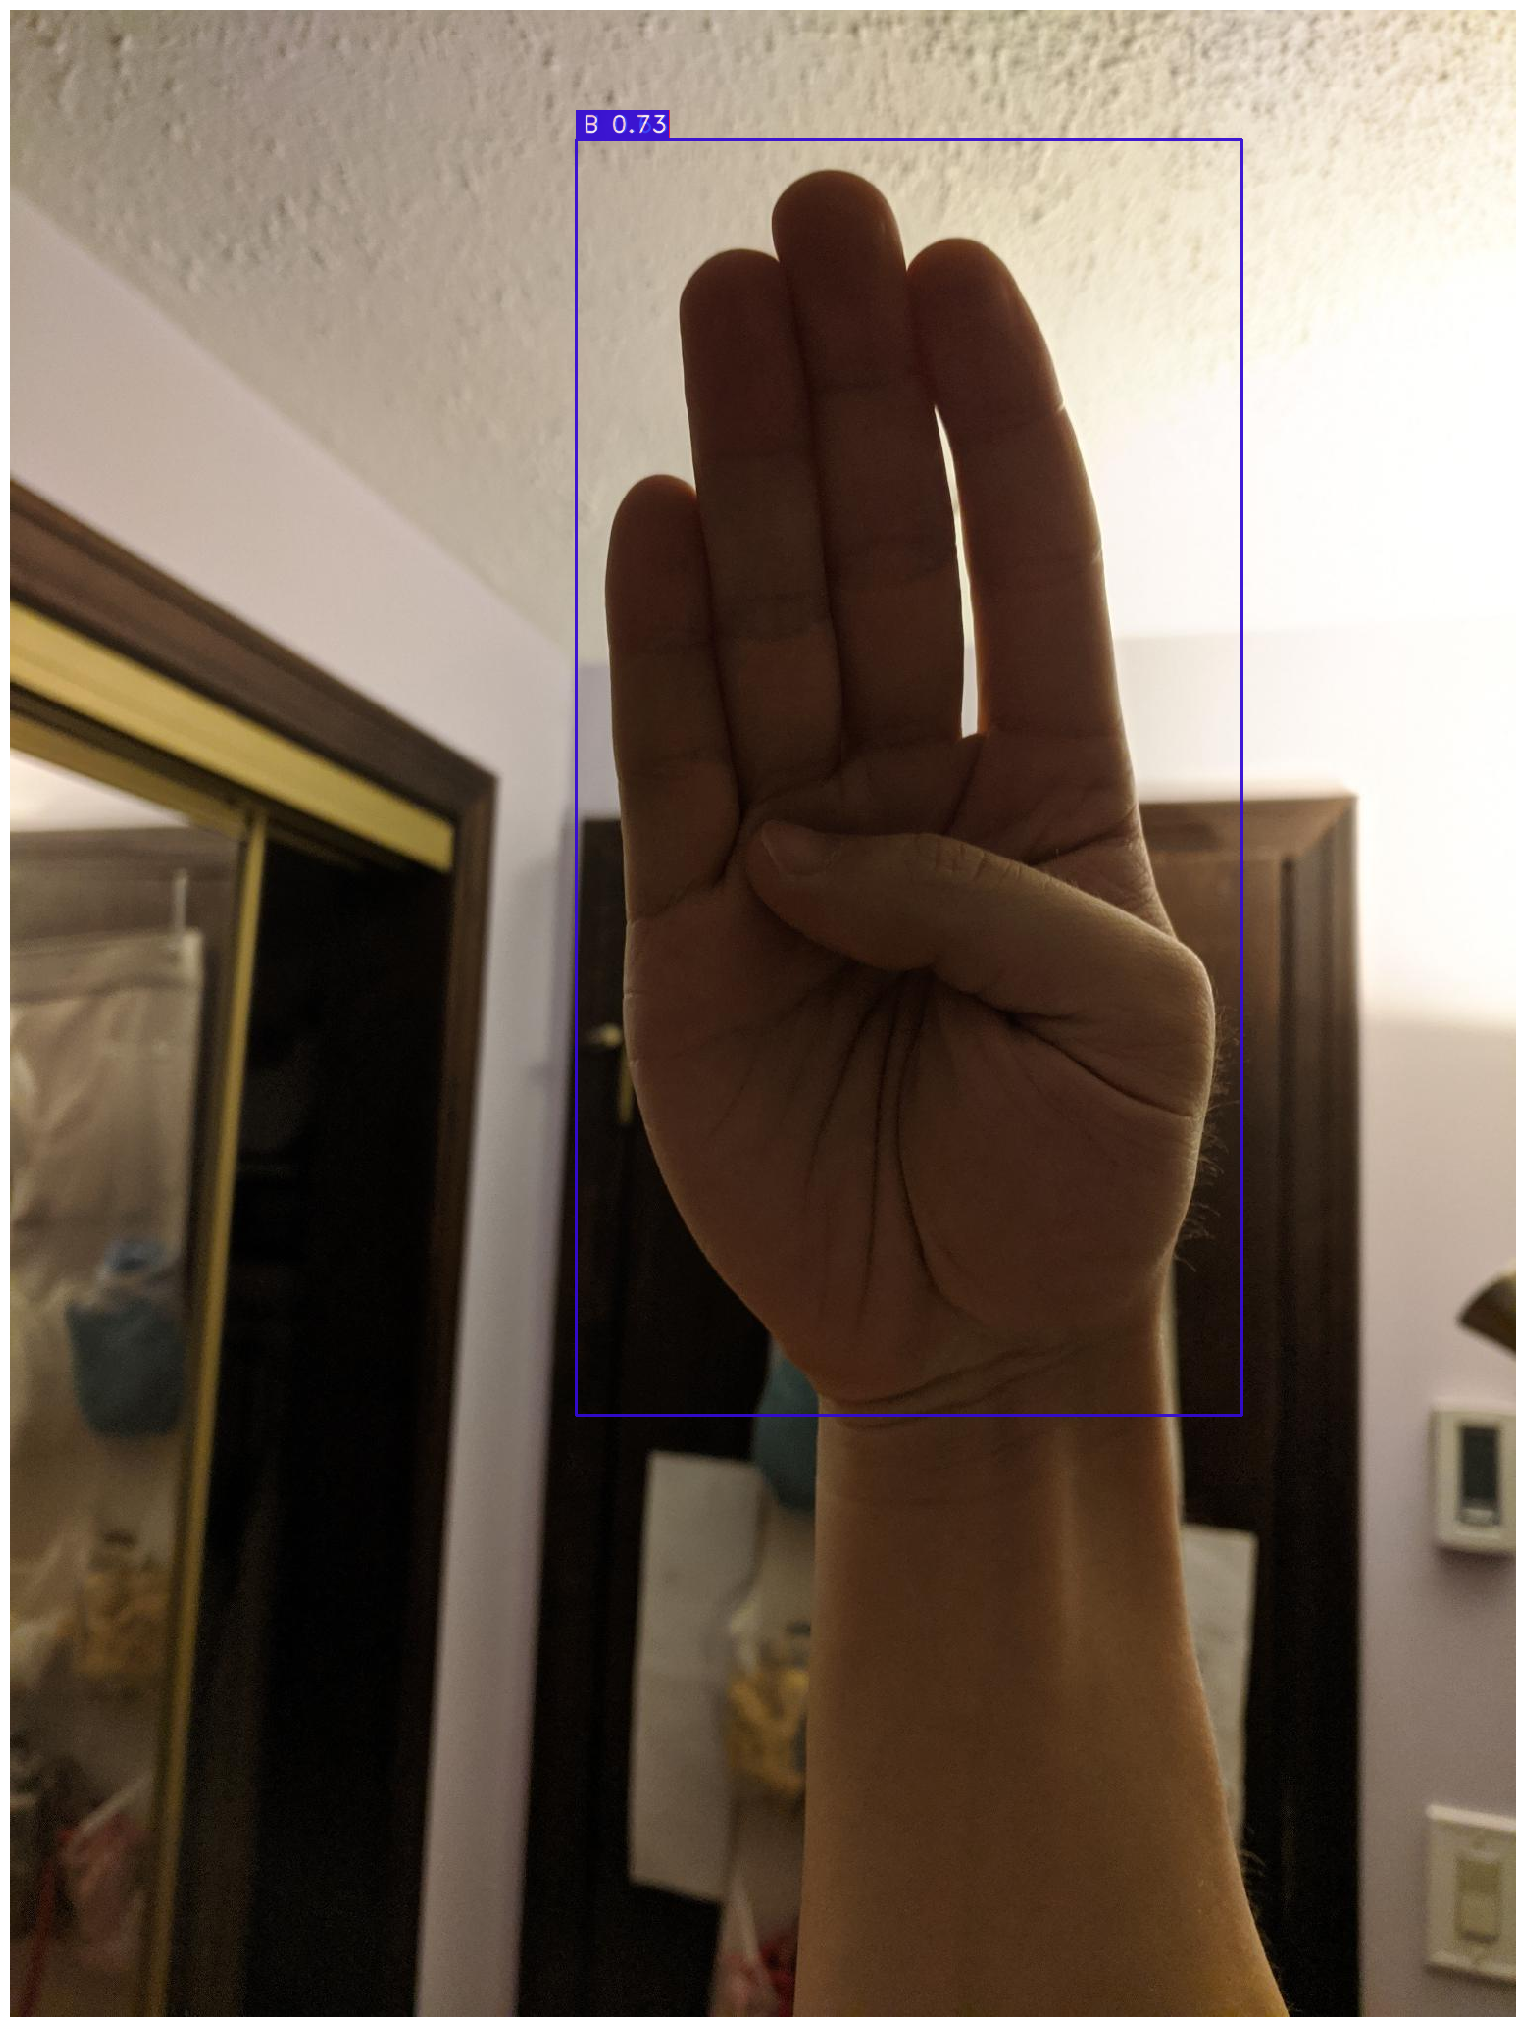

In [36]:
img_url = '/content/American-Sign-Language-Letters-6/valid/images/B5_jpg.rf.e1802440715c4bbb6de84d150dfe73b8.jpg'
best_model.predict(img_url).show()

#**Step 16: Testing on Video 1**

In [37]:
input_video_path = f"/content/demonew1.mp4"
output_video_path = "detections.mp4"

In [38]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [39]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 563/563 [00:11<00:00, 47.25it/s]


#**Display the Output Video**

In [42]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

#**Step 17: Testing on Video 2**

In [47]:
input_video_path = f"/content/American Sign Language Alphabet  Learn American Sign Language Letters.mp4"
output_video_path = "detections2.mp4"

In [48]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [1]:
best_model.to(device).predict(input_video_path).save(output_video_path)

NameError: ignored

#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections2.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)